# WEEK 4. Visualization and Interpretability

## Ungraded Lab 3: Saliency

Like class activation maps, saliency maps also tells us what parts of the image the model is focusing on when making its predictions.
- The main difference is in saliency maps, we are just shown the relevant pixels instead of the learned features.
- You can generate saliency maps by getting the gradient of the loss with respect to the image pixels.
- This means that changes in certain pixels that strongly affect the loss will be shown brightly in your saliency map.

Let's see how this is implemented in the following sections.

### Contents - YC 2025.06.07 Sat
0. Imports
1. Build the model (self-built, not Inception V3)
2. Preprocess the image
3. Compute Gradients
4. Visualize the results

### Comments: 
In this notebook we never trained a model. Instead it's just use `pretrained` model (`YC's own` or `InceptionV3`) to illustrate:
- how `gradient is calculated`, and
- how to `visualize` a `superimposed` result of orginal image and gradients.

## 0. Imports

In [1]:
# %tensorflow_version 2.x

import tensorflow as tf
# import tensorflow_hub as hub    ### There is compatibility issue between "tensorflow" and "tensorflow_hub"
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
print(tf.__version__)
# print(hub.__version__)

2.19.0


## 1. Build the model (`self-built`, not `Inception V3`)

For the classifier, you will use the [Inception V3 model](https://arxiv.org/abs/1512.00567) available in [Tensorflow Hub](https://tfhub.dev/google/tf2-preview/inception_v3/classification/4). This has pre-trained weights that is able to detect 1001 classes. You can read more [here](https://tfhub.dev/google/tf2-preview/inception_v3/classification/4).

In [ ]:
# grab the model from Tensorflow hub and append a softmax activation
model = tf.keras.Sequential([
    hub.KerasLayer('https://tfhub.dev/google/tf2-preview/inception_v3/classification/4'),
    tf.keras.layers.Activation('softmax')
])

# build the model based on a specified batch input shape
model.build([None, 300, 300, 3])

### `Inception V3` is loaded from TF_hub, which has complicated compatibility issue with TF. I decided not to use this model, instead using the `self-built` and `self-trained` model from final `assignment of WEEK 4`.

In [3]:
import keras
from keras.models import Sequential,Model
from keras.layers import Dense,Conv2D,Flatten,MaxPooling2D,GlobalAveragePooling2D

# YOUR CODE HERE
model = Sequential()

model.add(keras.Input(shape=(300,300,3)))
model.add(Conv2D(16,kernel_size=(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32,kernel_size=(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64,kernel_size=(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128,kernel_size=(3,3),activation='relu',padding='same'))
model.add(GlobalAveragePooling2D())
model.add(Dense(2,activation='sigmoid'))

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 300, 300, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 150, 150, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 150, 150, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 97,698 (381.63 KB)

 Trainable params: 97,698 (381.63 KB)

 Non-trainable params: 0 (0.00 B)

In [4]:
# load the pretrained weights
model.load_weights('15_epochs.h5')
# model.load_weights('YC20250606.weights.h5')

In [5]:
# build the model based on a specified batch input shape
model.build([None, 300, 300, 3])

## 2. Preprocess the image

The image needs to be preprocessed before being fed to the model. This is done in the following steps:

1. The dimension of   img is (300, 300, 3) <class 'numpy.ndarray'>
2. The dimension of image is (1, 300, 300, 3) <class 'numpy.ndarray'>


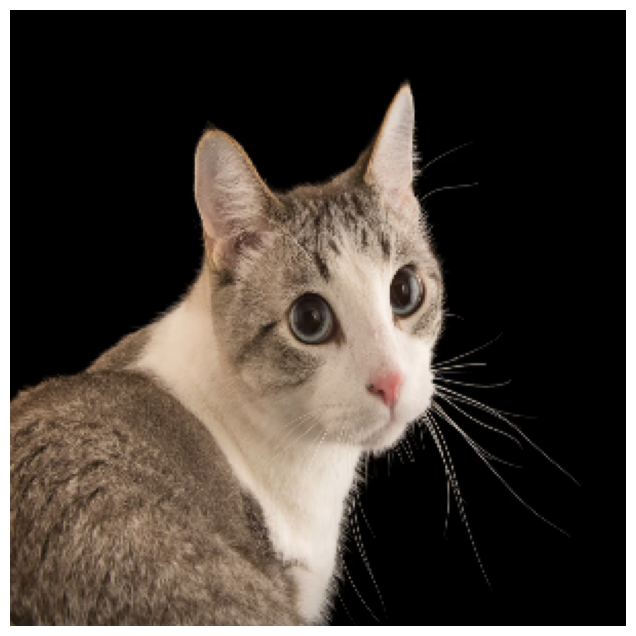

In [6]:
# read the image
img = cv2.imread('cat_test.jpg')

# format it to be in the RGB colorspace
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# resize to 300x300 and normalize pixel values to be in the range [0, 1]
img = cv2.resize(img, (300, 300)) / 255.0

# add a batch dimension in front
image = np.expand_dims(img, axis=0)


print("=====================================================================")
print("1. The dimension of   img is",   img.shape, type(img))
print("2. The dimension of image is", image.shape, type(image))
print("=====================================================================")

# We can now preview our input image.
plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.axis('off')
plt.show()

We can now preview our input image.

## 3. Compute Gradients

You will now get the gradients of the loss with respect to the input image pixels. This is the key step to generate the map later.

In [7]:
#  Cat's class ID in YC's model ^_^!!!
class_index = 0   

#  Dog's class ID in YC's model ^_^!!!
# class_index = 1   

# number of classes in the model's training data
num_classes = 2  

# convert to one hot representation to match our softmax activation in the model definition
expected_output = tf.one_hot([class_index] * image.shape[0], num_classes)

expected_output

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[1., 0.]], dtype=float32)>

## Calculate the `Gradient` w.r.t. `input image` ****

### a. tape.watch(inputs)

### b. `Loss` is calculate from `expected_output` + `predictions`

 - categorical_crossentropy

### c. gradients = tape.gradient(loss, inputs)

In [8]:
with tf.GradientTape() as tape:
    # cast image to float
    inputs = tf.cast(image, tf.float32)

    # watch the input pixels
    tape.watch(inputs)

    # generate the predictions
    predictions = model(inputs)

    # get the loss
    loss = tf.keras.losses.categorical_crossentropy(
        expected_output, predictions
    )

# get the gradient with respect to the inputs
gradients = tape.gradient(loss, inputs)

In [9]:
### a. show expected_output 
expected_output

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[1., 0.]], dtype=float32)>

In [10]:
### b. show predictions
predictions

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.83849525, 0.13459466]], dtype=float32)>

In [11]:
### c. show loss: from expected_output + predictions
loss

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.02951664], dtype=float32)>

## 4. Visualize the results

Now that you have the gradients, you will do some postprocessing to generate the saliency maps and overlay it on the image.

In [12]:
# reduce the RGB image to grayscale
grayscale_tensor = tf.reduce_sum(tf.abs(gradients), axis=-1)

# normalize the pixel values to be in the range [0, 255].
# the max value in the grayscale tensor will be pushed to 255.
# the min value will be pushed to 0.
normalized_tensor = tf.cast(
    255
    * (grayscale_tensor - tf.reduce_min(grayscale_tensor))
    / (tf.reduce_max(grayscale_tensor) - tf.reduce_min(grayscale_tensor)),
    tf.uint8,
)

# remove the channel dimension to make the tensor a 2d tensor
normalized_tensor = tf.squeeze(normalized_tensor)

Let's do a little sanity check to see the results of the conversion.

In [13]:
# max and min value in the grayscale tensor
print(np.max(grayscale_tensor[0]))
print(np.min(grayscale_tensor[0]))
print()

# coordinates of the first pixel where the max and min values are located
max_pixel = np.unravel_index(np.argmax(grayscale_tensor[0]), grayscale_tensor[0].shape)
min_pixel = np.unravel_index(np.argmin(grayscale_tensor[0]), grayscale_tensor[0].shape)
print(max_pixel)
print(min_pixel)
print()

# these coordinates should have the max (255) and min (0) value in the normalized tensor
print(normalized_tensor[max_pixel])
print(normalized_tensor[min_pixel])

0.009648427
0.0

(149, 148)
(179, 115)

tf.Tensor(255, shape=(), dtype=uint8)
tf.Tensor(0, shape=(), dtype=uint8)


You should get something like:

```
1.2167013
0.0

(203, 129)
(0, 299)

tf.Tensor(255, shape=(), dtype=uint8)
tf.Tensor(0, shape=(), dtype=uint8)
```

Now let's see what this looks like when plotted. The white pixels show the parts the model focused on when classifying the image.

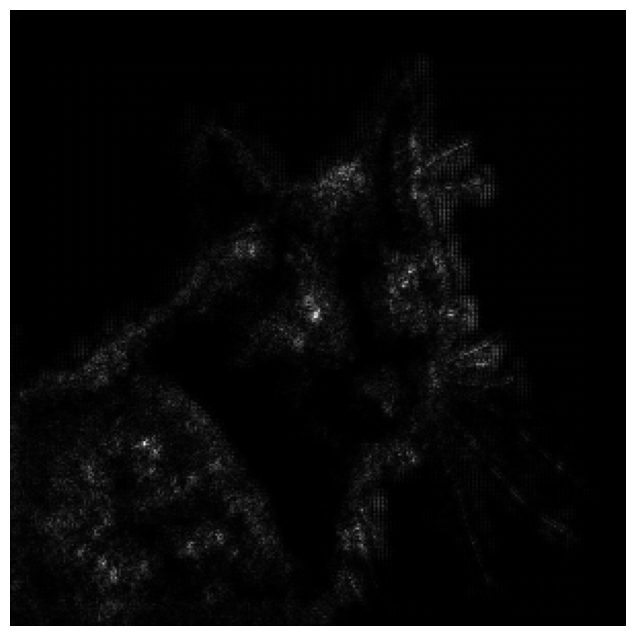

In [14]:
plt.figure(figsize=(8, 8))
plt.axis('off')
plt.imshow(normalized_tensor, cmap='gray')
plt.show()

Let's superimpose the normalized tensor to the input image to get more context. You can see that the strong pixels are over the husky and that is a good indication that the model is looking at the correct part of the image.

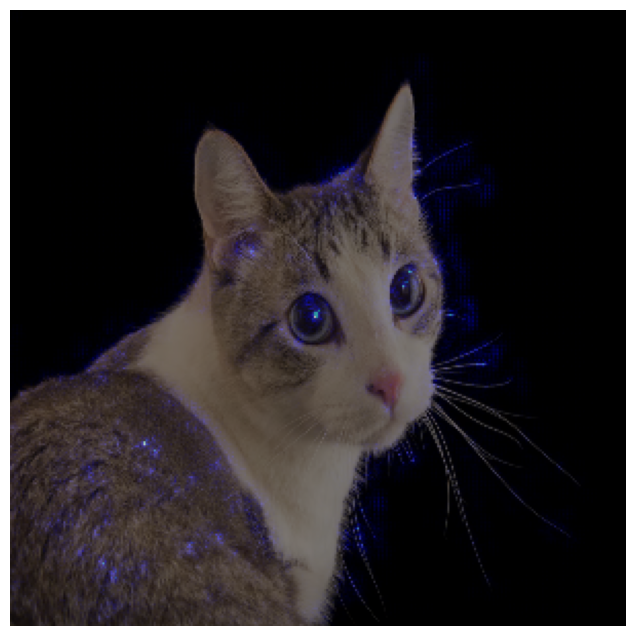

In [15]:
gradient_color = cv2.applyColorMap(normalized_tensor.numpy(), cv2.COLORMAP_HOT)
gradient_color = gradient_color / 255.0
super_imposed = cv2.addWeighted(img, 0.5, gradient_color, 0.5, 0.0)

plt.figure(figsize=(8, 8))
plt.imshow(super_imposed)
plt.axis('off')
plt.show()